<a href="https://colab.research.google.com/github/gabrie1-s/cnn-1d/blob/combined_approaches/cnn_2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from pathlib import Path
import scipy.io
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pandas as pd
from sklearn.preprocessing import normalize, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.stats import zscore

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#1. Aquisição dos Dados

In [3]:
data = Path('drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/data')

signals = []
classes =[]

for value in sorted(data.glob('*.mat')):
  signal = scipy.io.loadmat(value)
  signal = np.array(signal["val"], dtype='float')[0]
  signals.append(signal)
  # print(value)

In [4]:
classification_path = os.path.join(data, "classification.txt")
with open(classification_path) as f:
    classes = f.readlines()

for i in range(0, len(classes)):
  classes[i] = classes[i][classes[i].find(','):]
  classes[i] = classes[i][: classes[i].find('\n')]
  classes[i] = classes[i].replace(",", "")

# classes = classes[0: -1]

#2. Preprocessamento

### 2.1 Análise da distribuição das classes

In [5]:
d = {'signals': signals, 'classes': classes}
df = pd.DataFrame(data=d)
a = df.groupby('classes')

In [6]:
for i in ['N', 'O', 'A', '~']:
  print(i)
  aux = []

  for j in a.get_group(i)["signals"]:
    aux.append(len(j))

  print('Média:', round(np.mean(aux), 2))
  print("Std:", round(np.std(aux), 2))
  print("Qntd:", len(aux))
  print("Min:", min(aux))
  print("---------------")

N
Média: 9633.38
Std: 2991.84
Qntd: 5076
Min: 2714
---------------
O
Média: 10288.52
Std: 3528.74
Qntd: 2415
Min: 2738
---------------
A
Média: 9703.41
Std: 3694.64
Qntd: 758
Min: 2996
---------------
~
Média: 7313.63
Std: 3122.42
Qntd: 279
Min: 2808
---------------


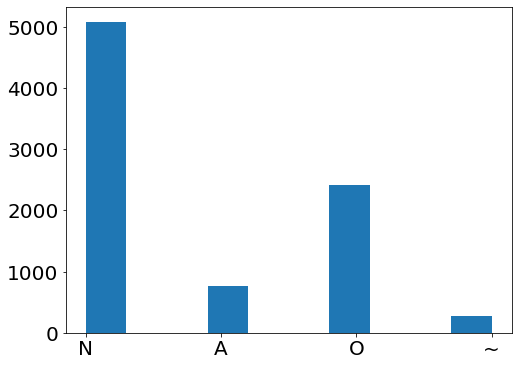

In [7]:
plt.rcParams.update({'font.size': 20})

df["classes"].hist(
    figsize=(8, 6),
    grid = False,
    bins = 10,
)
plt.xticks(range(4))
# plt.savefig('init_distri.png')
plt.show()

### 2.2 Janelamento dos dados de treino

In [8]:
intersection = 100
window_size = 500
windows_array = ["max","max","max", "max"]
classes_array = ['N', 'O', 'A', '~']

In [9]:
def window(signal, intersection, window_size, n):
  s_size = len(signal)
  max_n = (s_size-intersection)/(window_size - intersection)
  samples = []
  
  if  n == "max" or n > max_n:
    n = max_n
    n = math.floor(n)
    
  max_begin = s_size - (n*(window_size) - (n-1)*intersection) + 1
  init = random.randrange(max_begin)
  for i in range(0, n):
    begin = init + i*window_size - i*intersection
    end = begin + window_size
    samples.append(signal[begin:end])

  
  return samples

In [10]:
def embalance_data(df, classes_array, windows_array, intersection, window_size):

  a = df.groupby('classes')
  d_train = df.copy()
  d_train = d_train.iloc[0:0]


  idx = -1
  for i in classes_array:
    aux = []
    idx += 1

    for index, row in a.get_group(i).iterrows():
      samples = window(row["signals"], intersection, window_size,  windows_array[idx])
      
      for k in range(len(samples)):
        d_train = d_train.append({'signals': samples[k], 'classes': i}, ignore_index=True)

  return d_train

In [11]:
x_rem, x_test, y_rem, y_test = train_test_split(df["signals"], df["classes"], test_size=0.25)
x_train, x_valid, y_train, y_valid = train_test_split(x_rem, y_rem, test_size=0.1)

d_aux_train = pd.DataFrame({'signals': x_train, 'classes': y_train})
d_train = embalance_data(d_aux_train, classes_array, windows_array, intersection, window_size)

d_aux_valid = pd.DataFrame({'signals': x_valid, 'classes': y_valid})
d_valid = embalance_data(d_aux_valid, classes_array, windows_array, intersection, window_size)

b = d_train.groupby('classes')

for i in ['N','O', 'A', '~']:
  print(i)
  aux = []

  for j in b.get_group(i)["signals"]:
    aux.append(len(j))

  print('Média:', round(np.mean(aux), 2))
  print("Std:", round(np.std(aux), 2))
  print("Qntd:", len(aux))
  print("Min:", min(aux))
  print("---------------")

N
Média: 500.0
Std: 0.0
Qntd: 81833
Min: 500
---------------
O
Média: 500.0
Std: 0.0
Qntd: 40147
Min: 500
---------------
A
Média: 500.0
Std: 0.0
Qntd: 11718
Min: 500
---------------
~
Média: 500.0
Std: 0.0
Qntd: 3506
Min: 500
---------------


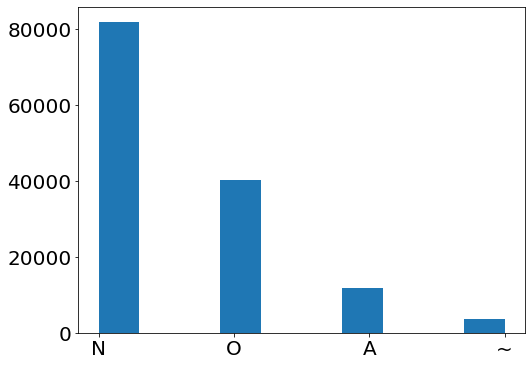

In [12]:
plt.rcParams.update({'font.size': 20})

d_train["classes"].hist(
    figsize=(8, 6),
    grid = False,
    bins = 10,
)
plt.xticks(range(4))
# plt.savefig('end_distri.png')
plt.show()

###2.4 Grayscale transformation



In [14]:
import cv2
import json

In [26]:
def gray_img(vector):
  plt.rcParams.update({'figure.max_open_warning': 0})
  imgs = []

  jsonFile = open("imgs.json", "w")


  for idx, i in enumerate(vector):
    fig = plt.figure(frameon=False)
    plt.plot(i)
    plt.xticks([]), plt.yticks([])
    for spine in plt.gca().spines.values():
      spine.set_visible(False)

    size = fig.get_size_inches()*fig.dpi

    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(int(size[0]), int(size[1]), 3)
    img = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])

    pin = {"idx": idx}
    img = {"data": img.tolist()}
    img = json.dumps(img)
    line = json.loads(img)
  
    # appending the data
    line.update(pin)
    
    # the result is a JSON string:
    jsonString = json.dumps(line)
    jsonFile.write(jsonString)

    plt.close(fig)
  
  jsonFile.close()
  return imgs

KeyboardInterrupt: ignored

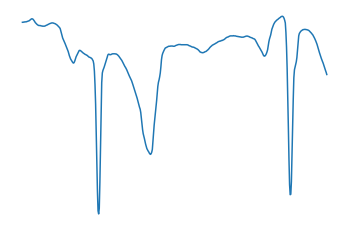

In [27]:
y_train = d_train["classes"]
d_train = gray_img(d_train["signals"])

#3. Implementação da CNN

##3.1 Descoberta dos hyperparâmetros (Otimização Bayseana)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D

from keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl

In [ ]:
y_train = pd.get_dummies(d_train["classes"])
y_valid = pd.get_dummies(d_valid["classes"])

x_train = list(d_train["signals"])
x_valid = list(d_valid["signals"])

x_train = np.array(x_train)
x_valid = np.array(x_valid)
x_test = np.array(x_test)

In [ ]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
# x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], 1)

In [ ]:
# Import packages
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score

pd.set_option("display.max_columns", None)

from sklearn import metrics
import tensorflow as tf

In [ ]:
score_acc = make_scorer(accuracy_score)

In [ ]:
len(x_train[0])

In [ ]:
input_shape = len(x_train[0])
k1 = 5
k2 = 3
n = math.floor(input_shape/(k1+k2-2))
nn_input = input_shape % (k1+k2-2)

classificador = Sequential()

for i  in range(0, 5):
  if i == 0:
    classificador.add(Conv1D(filters=32, kernel_size = k1, input_shape = (input_shape, 1), activation = "relu"))
  else:
      classificador.add(Conv1D(filters=32, kernel_size = k1, activation = "relu"))
  # BatchNormalization()
  
  classificador.add(Conv1D(filters=64, kernel_size = k2, activation = "relu"))
  # BatchNormalization()
  # classificador.add(Conv1D(filters=32, kernel_size = k2, activation = "relu"))
  classificador.add(MaxPooling1D(pool_size=2))

classificador.add(Flatten())

classificador.add(Dense(units=64, activation='relu'))
classificador.add(Dense(units=32, activation='relu'))
classificador.add(Dense(units=16, activation='relu'))

classificador.add(Dense(4, activation="softmax"))

classificador.compile(loss='categorical_crossentropy', optimizer=Adamax(learning_rate=0.01), metrics=["accuracy"])


es = EarlyStopping(monitor="accuracy", mode='max', verbose=0, patience=15)

history = classificador.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=150, batch_size=128, callbacks=es, verbose=1)



In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig("history.png")
plt.show()

In [ ]:
str(type(classificador.layers[0])) == "<class 'keras.layers.convolutional.conv1d.Conv1D'>"

In [ ]:
model_weights =[]
for i in classificador.layers:
  layer = "<class 'keras.layers.convolutional.conv1d.Conv1D'>"
  if str(type(i)) == layer:
    model_weights.append(i.get_weights())

In [ ]:
input_shape = len(x_train[0])
k1 = 5
k2 = 3
n = math.floor(input_shape/(k1+k2-2))
nn_input = input_shape % (k1+k2-2)

model = Sequential()

for i  in range(0, 5):
  if i == 0:
    model.add(Conv1D(filters=32, kernel_size = k1, input_shape = (input_shape, 1), activation = "relu"))
  else:
    model.add(Conv1D(filters=32, kernel_size = k1, activation = "relu"))
  
  model.add(Conv1D(filters=64, kernel_size = k2, activation = "relu"))
  model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

In [ ]:
count = 0
for i in model.layers:
  layer = "<class 'keras.layers.convolutional.conv1d.Conv1D'>"
  if str(type(i)) == layer:
    i.set_weights(model_weights[count])
    count += 1

In [ ]:
model.layers[0].get_weights()

In [ ]:
def pooling(array, type):
  array_size = array.shape[1]
  array_qnt = array.shape[0]
  mp_vector = []

  for j in range(0, array_size):
    aux = []

    for i in range(0, array_qnt):
      aux.append(array[i][j])
      
    if type == "max":
      mp_vector.append(max(aux))

    elif  type == "avg":
      mp_vector.append(np.mean(aux))

  return mp_vector

In [ ]:
from keras import backend as K

In [ ]:
def combine_windows(df):

  get_final_output = K.function([model.layers[0].input],
                                  [model.layers[-1].output])

  new_inputs = []

  for element in df["signals"]:
    samples = window(element, intersection, window_size, "max")
    outputs = []

    for sample in samples:
      sample = np.array(list(sample))
      sample = sample.reshape(1, sample.shape[0], 1)
      
      output = get_final_output(sample)
      outputs.append(output)


    outputs = np.array(outputs)
    outputs = outputs.reshape(outputs.shape[0], outputs.shape[-1])

    max_p = pooling(outputs, "max")
    avg_p = pooling(outputs, "avg")
    new_inputs.append(max_p + avg_p)

  return new_inputs


In [ ]:
pip install xgboost

In [ ]:
import xgboost as xgb

y_new = d_aux_train["classes"]
y_new = np.array(y_new)

new_inputs = combine_windows(d_aux_train)
new_inputs = np.array(new_inputs)
new_inputs = new_inputs.reshape(new_inputs.shape[0], new_inputs.shape[1])

xgb_cl = xgb.XGBClassifier()
xgb_cl.fit(new_inputs, y_new)

In [ ]:
valid_inp = combine_windows(d_aux_valid)

y_new_val = d_aux_valid["classes"]
y_new = np.array(y_new_val)

valid_inp = np.array(valid_inp)
valid_inp = valid_inp.reshape(valid_inp.shape[0], valid_inp.shape[1])

y_pred = xgb_cl.predict(valid_inp)

In [ ]:
accuracy_score(y_new_val, y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

cf_matrix = confusion_matrix(y_new_val, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['A', 'N', 'O', '~'])
cm_display.plot()
# plt.savefig("test.png")

In [ ]:
from sklearn.metrics import classification_report 
 
relatorio = classification_report(y_new_val, y_pred) 
print(relatorio)